In [5]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, RateRule, \
                      AssignmentRule, FunctionDefinition
print(gillespy2.__version__)

1.5.11


From: https://github.com/StochSS/GillesPy2/commit/2777b5e23d7cd3124a9000925ba4ff256f80cd03


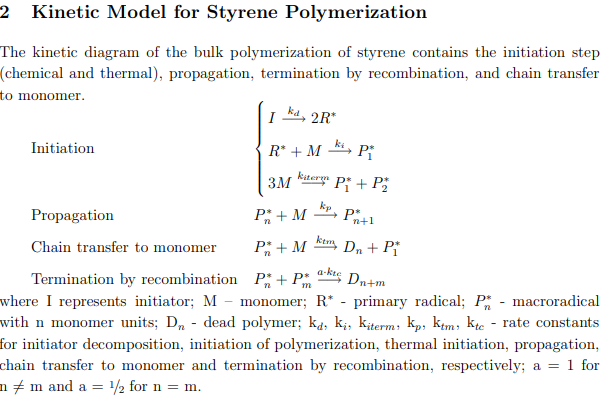

In [6]:
from IPython import display
print("From: https://github.com/StochSS/GillesPy2/commit/2777b5e23d7cd3124a9000925ba4ff256f80cd03")
display.Image("https://user-images.githubusercontent.com/85592612/121273574-ec503700-c89e-11eb-9aeb-ad425fd1f153.png")

**From:** Curteanu, Silvia. “Modeling and Simulation of Free Radical Polymerization of Styrene under Semibatch Reactor Conditions.” Open Chemistry, vol. 1, no. 1, 2003, pp. 69–90., doi:10.2478/bf02479259.

### Building the Polymerization model in GillesPy2

Constructing this model in GillesPy2 reqires that we specify a maximum $n$ and $m$ that we are keeping track of. $n$, $m$, and $n+m$ must all be less than the maximum signed integer ($2^{31}-1$).  Then we create a new Species object for each state: $P_1$, $P_2$, ... $P_n$, and $D_1$, $D_2$, ... $D_{n+m}$.

In [20]:
class StyrenePolymerization(Model):
    def __init__(self, MAX_N=10):
        #
        Model.__init__(self, name="StyrenePolymerization")

        # First, choose a maximum value for the states
        max_state = MAX_N
        print(f"Creating Styrene Polymerization model, MAX_N={MAX_N}")
        # Create Species for all states
        # Variables
        self.add_species(Species(name="I", initial_value=100, mode="discrete"))
        self.add_species(Species(name="R", initial_value=0, mode="discrete"))
        self.add_species(Species(name="M", initial_value=100, mode="discrete"))
        for n in range(1,max_state):
            self.add_species(Species(name=f"P{n}", initial_value=0, mode="discrete"))
            self.add_species(Species(name=f"D{n}", initial_value=0, mode="discrete"))
        
        # Parameters
        self.add_parameter(Parameter(name="k_d",    expression="1"))
        self.add_parameter(Parameter(name="k_i",    expression="1"))
        self.add_parameter(Parameter(name="k_iterm",expression="1"))
        self.add_parameter(Parameter(name="k_p",    expression="1"))
        self.add_parameter(Parameter(name="k_tm",   expression="1"))
        self.add_parameter(Parameter(name="k_tm_2", expression="0.5"))  # for the a=1/2
        self.add_parameter(Parameter(name="k_tc",   expression="1"))

        # Initiation Reactions
        self.add_reaction(Reaction(reactants={'I':1}, 
                                   products={'R':2}, 
                                   rate=self.listOfParameters["k_d"]))
        self.add_reaction(Reaction(reactants={'R':1,'M':1}, 
                                   products={'P1':1}, 
                                   rate=self.listOfParameters["k_d"]))
        # Techically, you cannot have a trimer reaction is mass-action kinetics.
        # However, we can use a custom propensity to make it work.
        self.add_reaction(Reaction(reactants={'M':3}, 
                                   products={'R':2}, 
                                   propensity_function="k_iterm*M*(M-1)*(M-2)"))
        
        
        # Propagation: P_n + M => P_{n+1}
        for n in range(1,max_state-1):
            np1 = n+1
            self.add_reaction(Reaction(reactants={f"P{n}":1,'M':1}, 
                                products={f"P{np1}": 1}, 
                                rate=self.listOfParameters["k_p"]))
        # Chain transfer to monomer
        for n in range(1,max_state):
            self.add_reaction(Reaction(reactants={f"P{n}":1,'M':1}, 
                                products={f"D{n}":1,"P1":1}, 
                                rate=self.listOfParameters["k_tm"]))
        # Termination by recombination
        for n in range(1,max_state):
            for m in range(1,max_state):
                nm = n+m
                if( nm < max_state ):
                    if(n==m):
                        self.add_reaction(Reaction(
                                reactants={f"P{n}":1,f"P{m}":1}, 
                                products={f"D{nm}":1,"P1":1}, 
                                rate=self.listOfParameters["k_tm_2"]))
                    else:
                        self.add_reaction(Reaction(
                                reactants={f"P{n}":1,f"P{m}":1}, 
                                products={f"D{nm}":1,"P1":1}, 
                                rate=self.listOfParameters["k_tm"]))
        
        # Timespan: 0 -> 20 seconds
        self.timespan(np.arange(0, 20, 0.1))

In [21]:
model = StyrenePolymerization()

Creating Styrene Polymerization model, MAX_N=10


## Run Simulation

In [22]:
%time result = model.run()

CPU times: user 37.4 ms, sys: 19.7 ms, total: 57.1 ms
Wall time: 1.95 s


# Visualization

In [23]:
result.plotplotly()

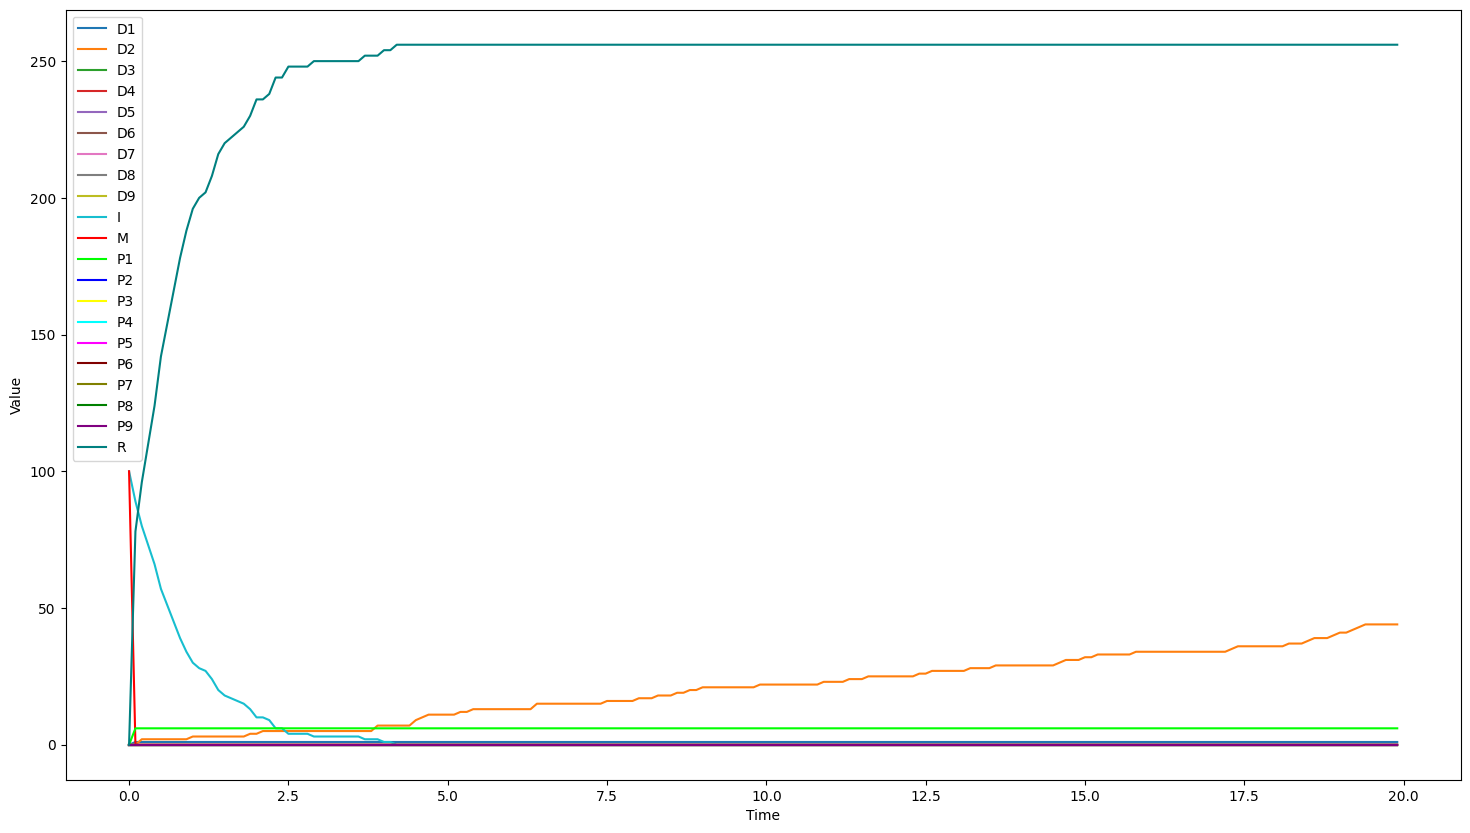

In [24]:
result.plot()